# Cut Implementations

By default I was using the error function, but I stumbled across some other implementations. This chapter explores some of the options.

Note: This will write out a file called `jax_cuts.py` which contains the source code so that the code can be tested in other places.

In [1]:
from util_nb import run_and_save

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

from jax_helpers import data_sig_j, data_back_j
from typing import Callable, Dict
import functools as ft
import tabulate

## Error Function

This was where I started. Lets develop a few tools here we can use later on to define the error function.

In [3]:
def cut_erf(cut: float, data):
    "Take a jax array and calculate an error function on it"
    return (jax.lax.erf(data - cut) + 1) / 2.0


def sig_sqrt_b(f, sig_j, back_j):
    "Calculate the S/sqrt(B) for two 1D numpy arrays with the cut at cut."

    # Weight the data and then do the sum
    wts_sig = f(sig_j)
    wts_back = f(back_j)

    S = jnp.sum(wts_sig)
    B = jnp.sum(wts_back)

    return S / jnp.sqrt(B)

Setup some setup to plot the function and its grad - that we can re-use below.

Start with the function itself - or its average weight.

In [4]:
data_max = max(max(data_sig_j), max(data_back_j))
data_min = min(min(data_sig_j), min(data_back_j))
lower_limit = data_min - (abs(data_min) * 0.2)
upper_limit = data_max + (abs(data_max) * 0.2)

In [5]:
x_values = np.linspace(lower_limit, upper_limit, 100)

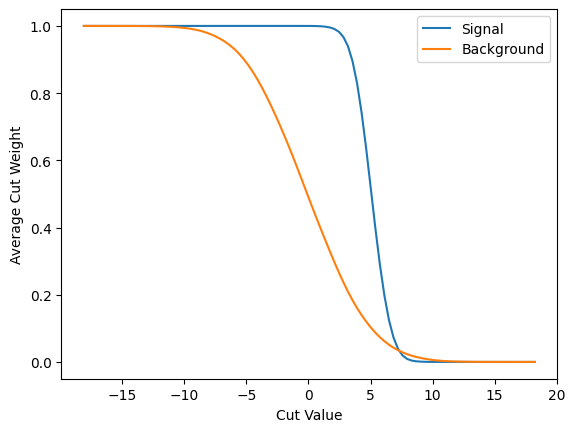

In [6]:
def plot_avg_weight(f: Callable):
    plt.plot(x_values, np.array([jnp.average(f(c, data_sig_j)) for c in x_values]), label='Signal')
    plt.plot(x_values, np.array([jnp.average(f(c, data_back_j)) for c in x_values]), label='Background')
    plt.xlabel('Cut Value')
    plt.ylabel('Average Cut Weight')
    plt.legend()
    plt.show()

plot_avg_weight(cut_erf)

Next lets look at the $S/\sqrt{B}$ background.

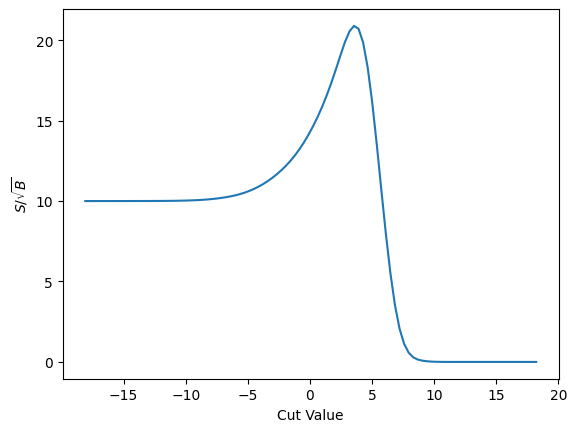

In [7]:
def plot_s_sqrt_b(f):
    plt.plot(x_values, np.array([sig_sqrt_b(ft.partial(f, c), data_sig_j, data_back_j) for c in x_values]))
    plt.xlabel('Cut Value')
    plt.ylabel(r'$S/\sqrt{B}$')
    plt.show()

plot_s_sqrt_b(cut_erf)

And finally the gradient of that.

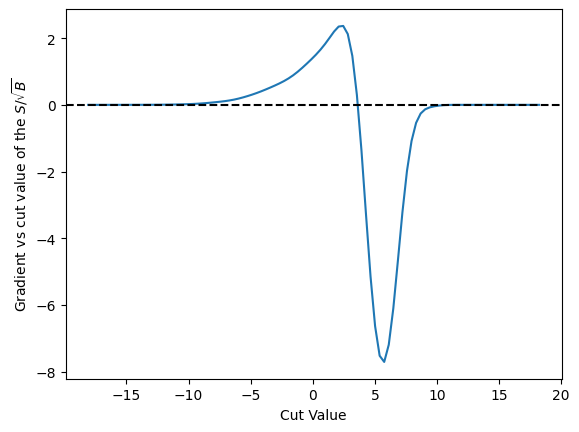

Cut Value,Gradient
-18.0856,3.23895e-08
-17.7188,2.60402e-07
-17.3521,1.60752e-06
-16.9854,7.64088e-06
-16.6187,2.80835e-05
16.7523,-6.30805e-26
17.119,-3.96212e-28
17.4857,-2.1521e-30
17.8525,-1.01308e-32
18.2192,-4.14167e-35


In [8]:
def plot_grad(f):
    def calc_by_c(c):
        return sig_sqrt_b(ft.partial(f, c), data_sig_j, data_back_j)

    g = jax.grad(calc_by_c)

    plt.plot(x_values, np.array([g(c) for c in x_values]))
    plt.xlabel('Cut Value')
    plt.ylabel(r'Gradient vs cut value of the $S/\sqrt{B}$')

    # And show a line where the zero is
    plt.axhline(0.0, color='black', linestyle='dashed')

    plt.show()

    # Finally, print out the last 5 and the first 5 items
    x_values_ends = list(x_values[0:5]) + list(x_values[-5:])
    g_values = [[c, float(g(c))] for c in x_values_ends]
    return tabulate.tabulate(g_values, headers=['Cut Value', 'Gradient'], tablefmt='html')

plot_grad(cut_erf)

The fact that things are exactly zero out beyond our cuts can be seen as a real problem here - it means if a minimization starts too far to the left or right then it will not have gradient value to push it towards where it might actually alter things.

## Sigmoid Function

I discovered this approach while looking at [`gradhep`](https://github.com/gradhep)'s [`relaxed` repo](https://github.com/gradhep/relaxed) - where for a [cut they use an exponential](https://github.com/gradhep/relaxed/blob/8654d8fa64e22a3da5efc3870a855e0d26b88e9a/src/relaxed/ops.py#L16).

In [9]:
def cut_sigmoid(cut: float, data):
    slope = 1.0
    return 1 / (1 + jnp.exp(-slope * (data - cut)))

Now we make the basic info plots for the average weight and the $S/\sqrt{B}$.

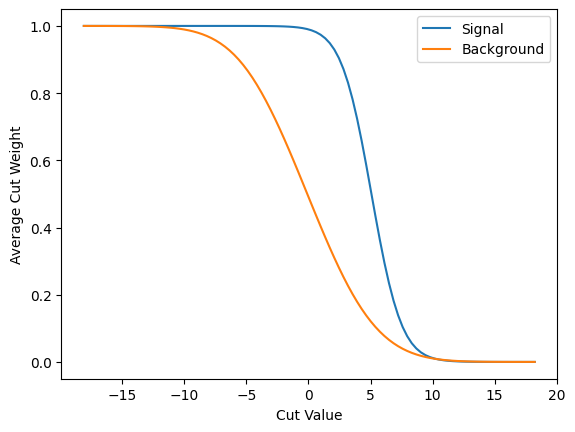

In [10]:
plot_avg_weight(cut_sigmoid)

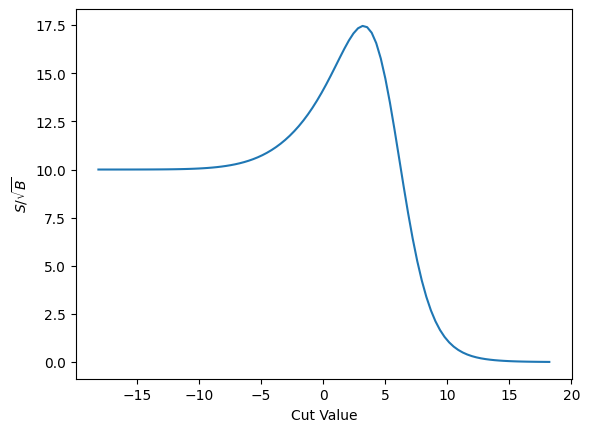

In [11]:
plot_s_sqrt_b(cut_sigmoid)

And finally the gradient

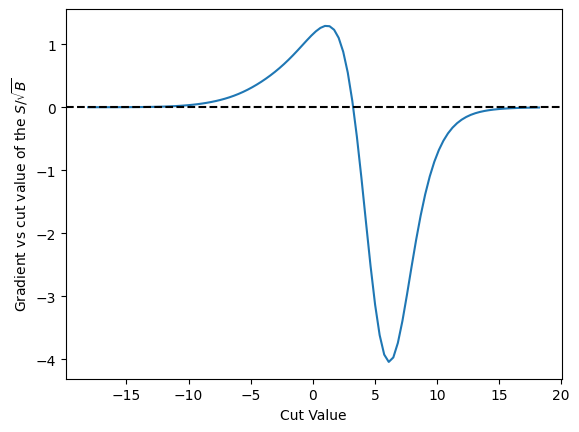

Cut Value,Gradient
-18.0856,8.77184e-05
-17.7188,0.000124676
-17.3521,0.000176179
-16.9854,0.000247079
-16.6187,0.000343248
16.7523,-0.0100272
17.119,-0.00814901
17.4857,-0.00665744
17.8525,-0.00546376
18.2192,-0.00450082


In [12]:
plot_grad(cut_sigmoid)

As we can see this approach suffers from similar problems. That said, it does behave more nicely than the error function I've been using up to now - and it takes longer before it trails off to "zero" here.

## Comparison

A more direct comparison of some of the plots.

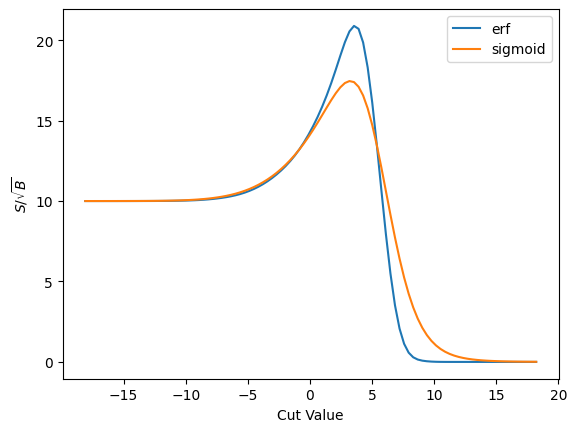

In [13]:
def plot_s_sqrt_b_multi(funcs: Dict[str, Callable]):
    for name, f in funcs.items():        
        plt.plot(x_values, np.array([sig_sqrt_b(ft.partial(f, c), data_sig_j, data_back_j) for c in x_values]), label=name)
    plt.xlabel('Cut Value')
    plt.ylabel(r'$S/\sqrt{B}$')
    plt.legend()
    plt.show()

plot_s_sqrt_b_multi({'erf': cut_erf, 'sigmoid': cut_sigmoid})

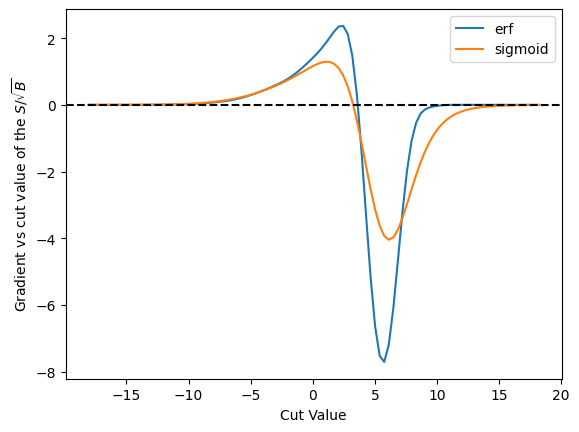

In [14]:
def plot_grad_multi(funcs: Dict[str, Callable]):
    for name, f in funcs.items():
        def calc_by_c(c):
            return sig_sqrt_b(ft.partial(f, c), data_sig_j, data_back_j)

        g = jax.grad(calc_by_c)

        plt.plot(x_values, np.array([g(c) for c in x_values]), label=name)

    plt.xlabel('Cut Value')
    plt.ylabel(r'Gradient vs cut value of the $S/\sqrt{B}$')

    # And show a line where the zero is
    plt.axhline(0.0, color='black', linestyle='dashed')

    plt.legend()
    plt.show()

plot_grad_multi({'erf': cut_erf, 'sigmoid': cut_sigmoid})